<a href="https://colab.research.google.com/github/kellyz04/APM-project/blob/master/CNN_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
! pip install pydicom

     |████████████████████████████████| 7.1MB 2.8MB/s 


# Data Pre Processing


In [3]:
import numpy as np
import pandas as pd
import pydicom
import os
from os import listdir

from os.path import isfile, join
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm_notebook as tqdm
from datetime import datetime

from math import ceil, floor, log
import cv2

import tensorflow as tf
import keras

import sys

# from keras_applications.resnet import ResNet50
# from keras_applications.inception_v3 import InceptionV3
from keras.callbacks import EarlyStopping
from sklearn.model_selection import ShuffleSplit
test_images_dir = '/content/drive/My Drive/Sample of Sampled Data/Test_Sample/'
train_images_dir = '/content/drive/My Drive/Sample of Sampled Data/'

Using TensorFlow backend.


In [0]:
def read_testset(filename="/content/drive/My Drive/Sample of Sampled Data/CSV Files/test_sample.csv"):
    df = pd.read_csv(filename)

    
    df = df.loc[:, ["Label", "Type", "ID_Image"]]
    df = df.set_index(['ID_Image', 'Type']).unstack(level=-1)
    
    return df

def read_trainset(filename="/content/drive/My Drive/Sample of Sampled Data/CSV Files/train_sample.csv"):
    df = pd.read_csv(filename)

    
    
    df = df.loc[:, ["Label", "Type", "ID_Image"]]
    df = df.set_index(['ID_Image', 'Type']).unstack(level=-1)
    
    return df

train_df = read_trainset()   
test_df = read_testset()

In [5]:
train_df.iloc[:5]

Label           ...                      
Type           any epidural  ... subarachnoid subdural
ID_Image                     ...                      
ID_0000f1657     0        0  ...            0        0
ID_0001dcc25     0        0  ...            0        0
ID_0004a5701     1        0  ...            0        1
ID_0005d340e     1        0  ...            1        0
ID_000a18499     0        0  ...            0        0

[5 rows x 6 columns]

In [0]:
train_df.columns = train_df.columns.get_level_values(1)
test_df.columns = test_df.columns.get_level_values(1)

In [0]:
train_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)

In [0]:
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):
    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)

    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img

In [0]:
def _read(path, desired_size):
    """Will be used in DataGenerator"""
    
    dcm = pydicom.dcmread(path)
    
    try:
        img = bsb_window(dcm)
    except:
        img = np.zeros(desired_size)
    
    
    img = cv2.resize(img, desired_size[:2], interpolation=cv2.INTER_LINEAR)
    
    return img

In [0]:
train_images = [f for f in listdir(train_images_dir) if isfile(join(train_images_dir, f))]
test_images = [f for f in listdir(test_images_dir) if isfile(join(test_images_dir, f))]

In [0]:
train_images_ID = [s.strip('.dcm') for s in train_images]
test_images_ID = [s.strip('.dcm') for s in test_images]

In [0]:
p_train = []
for i in train_images:
  dicom = _read(train_images_dir+i, (128, 128)) 
  p_train.append(dicom)
  
p_test = []
for i in test_images:
  dicom = _read(test_images_dir+i, (128, 128)) 
  p_test.append(dicom)


In [0]:
l_train =  list(zip(train_images_ID, p_train))
train_pixel = pd.DataFrame(l_train, columns = ['ID_Image' , 'pixel']) 
l_test =  list(zip(test_images_ID, p_test))
test_pixel = pd.DataFrame(l_test, columns = ['ID_Image' , 'pixel']) 
train_merge = train_df.merge(train_pixel, left_on='ID_Image', right_on='ID_Image', how='inner')
test_merge = test_df.merge(test_pixel, left_on='ID_Image', right_on='ID_Image', how='inner')

In [0]:
train_X = train_merge.drop(columns = ['ID_Image','any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural'])
train_X = np.stack(train_X['pixel'].tolist(),axis=0)
train_Y = np.array(train_merge[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']])
test_X = test_merge.drop(columns = ['ID_Image','any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural'])
test_X = np.stack(test_X['pixel'].tolist(),axis=0)
test_Y = np.array(test_merge[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']])


# CNN Model

In [0]:
import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input

In [0]:
from keras import backend as K

def weighted_log_loss(y_true, y_pred):
    """
    Can be used as the loss function in model.compile()
    ---------------------------------------------------
    """
    
    class_weights = np.array([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    out = -(         y_true  * K.log(      y_pred) * class_weights
            + (1.0 - y_true) * K.log(1.0 - y_pred) * class_weights)
    
    return K.mean(out, axis=-1)
def _normalized_weighted_average(arr, weights=None):
    """
    A simple Keras implementation that mimics that of 
    numpy.average(), specifically for this competition
    """
    
    if weights is not None:
        scl = K.sum(weights)
        weights = K.expand_dims(weights, axis=1)
        return K.sum(K.dot(arr, weights), axis=1) / scl
    return K.mean(arr, axis=1)

def weighted_loss(y_true, y_pred):
    """
    Will be used as the metric in model.compile()
    ---------------------------------------------
    
    Similar to the custom loss function 'weighted_log_loss()' above
    but with normalized weights, which should be very similar 
    to the official competition metric:
        https://www.kaggle.com/kambarakun/lb-probe-weights-n-of-positives-scoring
    and hence:
        sklearn.metrics.log_loss with sample weights
    """
    
    class_weights = K.variable([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    loss = -(        y_true  * K.log(      y_pred)
            + (1.0 - y_true) * K.log(1.0 - y_pred))
    
    loss_samples = _normalized_weighted_average(loss, class_weights)
    
    return K.mean(loss_samples)

def weighted_log_loss_metric(trues, preds):
    """
    Will be used to calculate the log loss 
    of the validation set in PredictionCheckpoint()
    ------------------------------------------
    """
    class_weights = [2., 1., 1., 1., 1., 1.]
    
    epsilon = 1e-7
    
    preds = np.clip(preds, epsilon, 1-epsilon)
    loss = trues * np.log(preds) + (1 - trues) * np.log(1 - preds)
    loss_samples = np.average(loss, axis=1, weights=class_weights)

    return - loss_samples.mean()

In [22]:
cnn_model = Sequential()
# Convolutional Layer 1:
cnn_model.add(Conv2D(32, kernel_size = (3, 3), activation = 'linear', input_shape = (128, 128, 3), padding = 'same'))
cnn_model.add(LeakyReLU(alpha = 0.1))
# Max Pooling Layer 1:
cnn_model.add(MaxPooling2D((2, 2),padding = 'same'))
# Convolutional Layer 2:
cnn_model.add(Conv2D(64, kernel_size = (3, 3), activation = 'linear', padding = 'same'))
cnn_model.add(LeakyReLU(alpha = 0.1))
# Max Pooling Layer 2:
cnn_model.add(MaxPooling2D((2, 2),padding = 'same'))
# Convolutional Layer 3:
cnn_model.add(Conv2D(128, kernel_size = (3, 3), activation = 'linear', padding = 'same'))
cnn_model.add(LeakyReLU(alpha = 0.1))
# Max Pooling Layer 3:
cnn_model.add(MaxPooling2D((2, 2),padding = 'same'))
# Flatten Preprocessing:
cnn_model.add(Flatten())
# Fully Connected Layer (Dense Layer):
cnn_model.add(Dense(128, activation = 'linear'))
cnn_model.add(LeakyReLU(alpha = 0.1))
# Output Layer (Dense Layer):
cnn_model.add(Dense(6, activation = 'sigmoid')) # choose one of them? # softmax

# Compile CNN model
cnn_model.compile(loss = "binary_crossentropy", optimizer = keras.optimizers.Adam(), metrics = [weighted_loss])
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 128)      

In [18]:
datagen = ImageDataGenerator(
    rotation_range = 30,
    horizontal_flip = True)
datagen.fit(train_X)

# Fits the model on batches with real-time data augmentation:
cnn_model_process = cnn_model.fit_generator(datagen.flow(train_X, train_Y, batch_size = 32),
                                                            steps_per_epoch = len(train_X) / 32, 
                                                            epochs = 20, verbose = 1, validation_data = (test_X, test_Y))
# cnn_model_process = cnn_model.fit(train_X, train_Y, batch_size = 32, epochs = 20, verbose = 1, validation_data = (test_X, test_Y))




Epoch 1/20





1/0 [==========================================================================================================] - 7s 7s/step - loss: 0.6999 - weighted_loss: 0.6987 - val_loss: 0.4804 - val_weighted_loss: 0.5259
Epoch 2/20
1/0 [==========================================================================================================] - 0s 14ms/step - loss: 0.4891 - weighted_loss: 0.5036 - val_loss: 0.4776 - val_weighted_loss: 0.5619
Epoch 3/20
1/0 [==========================================================================================================] - 0s 58ms/step - loss: 0.4373 - weighted_loss: 0.4693 - val_loss: 0.4860 - val_weighted_loss: 0.5412
Epoch 4/20
1/0 [==========================================================================================================] - 0s 99ms/step - loss: 0.3908 - weighted_loss: 0.4010 - val_loss: 0.5063 - val_weighted_loss: 0.5709
Epoch 5/20
1/0 [==============================================================================

# SHAP

In [19]:
!pip install shap

     |████████████████████████████████| 266kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.33.0-cp36-cp36m-linux_x86_64.whl size=382271 sha256=761db7b2bc0c682b61db219b94dc821c714ee671c59b3e9b649c57de4f2c75da
  Stored in directory: /root/.cache/pip/wheels/39/0f/88/a8124d43431284e10f263ffe449e119344c6145c3a165d186c
Successfully built shap


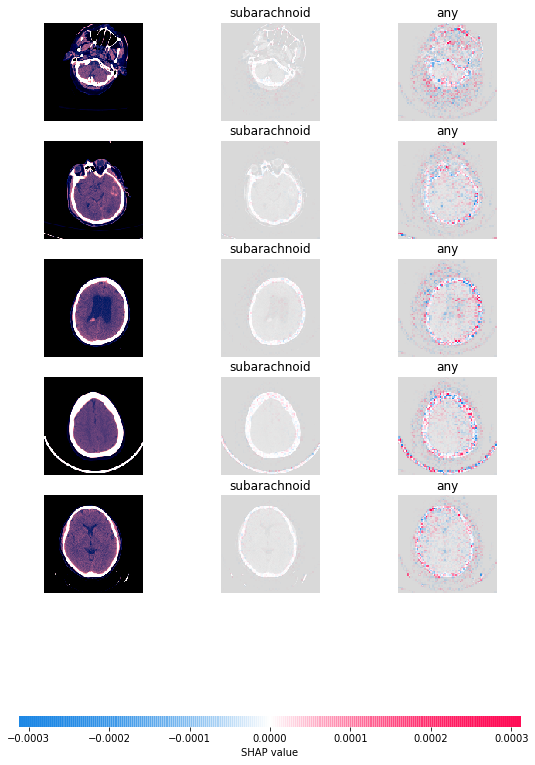

In [23]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import json
import shap

# load pre-trained model and choose two images to explain
# model = InceptionV3(weights='imagenet')
model = cnn_model
# X,y = shap.datasets.imagenet50()
to_explain = train_X[:5]


class_names = {'0':'any','1':'epidural','2':'intraparenchymal','3':'intraventricular','4':'subarachnoid','5':'subdural'}

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
    
e = shap.GradientExplainer(
    (model.layers[3].input, model.layers[-1].output),
    map2layer(train_X[:2000], 3),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 3), ranked_outputs=2)

# get the names for the classes 
index_names = np.vectorize(lambda x: class_names[str(x)])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain,index_names)